In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
sns.set()

from collections import OrderedDict

# Preprocessing
from sklearn.preprocessing import QuantileTransformer
# Algorithms
from tslearn.clustering import TimeSeriesKMeans
from tools import *

DATA_DIR = Path('../../data')
PROC_DIR = Path(DATA_DIR / 'processed')

OUT_DIR = Path('./out/tskmeans')
if not OUT_DIR.exists():
    OUT_DIR.mkdir(parents=True)

flow_columns = ['R [Rsun]', 'B [G]', 'alpha [deg]']
MAX_CLUSTERS = 13

/home/ivsaav/.local/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Load data

In [2]:
filenames = [f for f in PROC_DIR.iterdir()]

flows_dict = OrderedDict()
for f in filenames:
    flows_dict[f.stem] = pd.read_csv(f, usecols=['R [Rsun]', 'B [G]', 'alpha [deg]'])

## Scale Inputs

In [3]:
scaled_flows = pd.DataFrame()
scaler = QuantileTransformer(n_quantiles=1000, output_distribution='uniform')


unscaled_flows = list(flows_dict.values())
unscaled_flows = pd.concat(unscaled_flows, axis=0)

scaler.fit(unscaled_flows)
scaled_flows = scaler.transform(unscaled_flows)

scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
print(scaled_flows.shape)
print(scaled_flows.head())

(7533440, 3)
   R [Rsun]     B [G]  alpha [deg]
0  0.000000  0.971893     0.684680
1  0.002640  0.971887     0.684492
2  0.004004  0.971881     0.684301
3  0.006006  0.971875     0.684105
4  0.007007  0.971869     0.683907


# Magnetic Field - B [G]

In [4]:
# separate into file series
scaled_magnetic = [scaled_flows['B [G]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['B [G]']) // 640)]
scaled_magnetic = np.array(scaled_magnetic)
scaled_magnetic[0][:5]

unscaled_magnetic = [unscaled_flows['B [G]'][i*640 : i*640 + 640] for i in range(len(unscaled_flows['B [G]']) // 640)]
unscaled_magnetic = np.array(unscaled_magnetic)

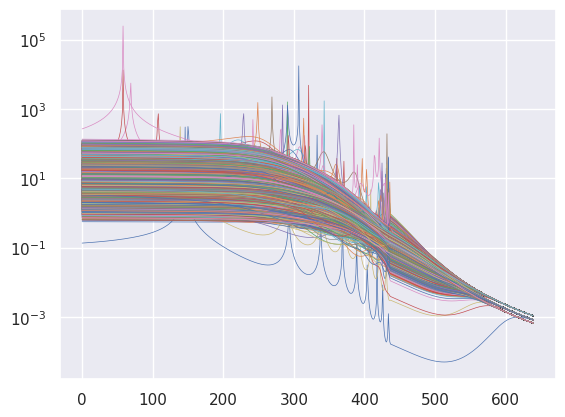

In [5]:
# plot scaled magnetic field
for b_line in unscaled_magnetic:
    plt.plot(b_line, linewidth=0.5)

plt.yscale('log')

## Time Series K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

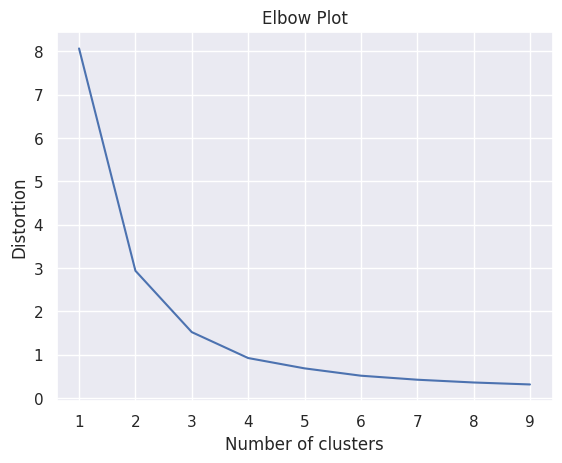

In [5]:
distortions = []
K = range(1,10)
for i in K:
    km = TimeSeriesKMeans(n_clusters=i, metric="euclidean", max_iter=500, random_state=0)
    km.fit(scaled_magnetic)
    distortions.append(km.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')

In [5]:
df = clustering_metrics(TimeSeriesKMeans, scaled_magnetic, {"random_state" : 0, "metric" : "euclidean", "max_iter" : 500})
df

,n_clusters,silhouette,davies_bouldin,calinski_harabasz
0,2,0.524460,0.669112,20376.433338
1,3,0.510591,0.627782,25585.983267
2,4,0.497516,0.606133,30677.339757
3,5,0.458366,0.648151,31995.158559
4,6,0.448811,0.670774,34394.630034
5,7,0.431082,0.695349,35462.210419
6,8,0.421746,0.712046,36070.499759
7,9,0.403426,0.738000,36368.845778


In [7]:
print(df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrrr}
\toprule
n_clusters & silhouette & davies_bouldin & calinski_harabasz \\
\midrule
2 & 0.524 & 0.669 & 20376.433 \\
3 & 0.511 & 0.628 & 25585.983 \\
4 & 0.498 & 0.606 & 30677.340 \\
5 & 0.458 & 0.648 & 31995.159 \\
6 & 0.449 & 0.671 & 34394.630 \\
7 & 0.431 & 0.695 & 35462.210 \\
8 & 0.422 & 0.712 & 36070.500 \\
9 & 0.403 & 0.738 & 36368.846 \\
\bottomrule
\end{tabular}



In [6]:
# rule of thumb number of clusters 
cluster_count = 4
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="euclidean", max_iter=100, random_state=0)

mag_labels = km.fit_predict(scaled_magnetic)

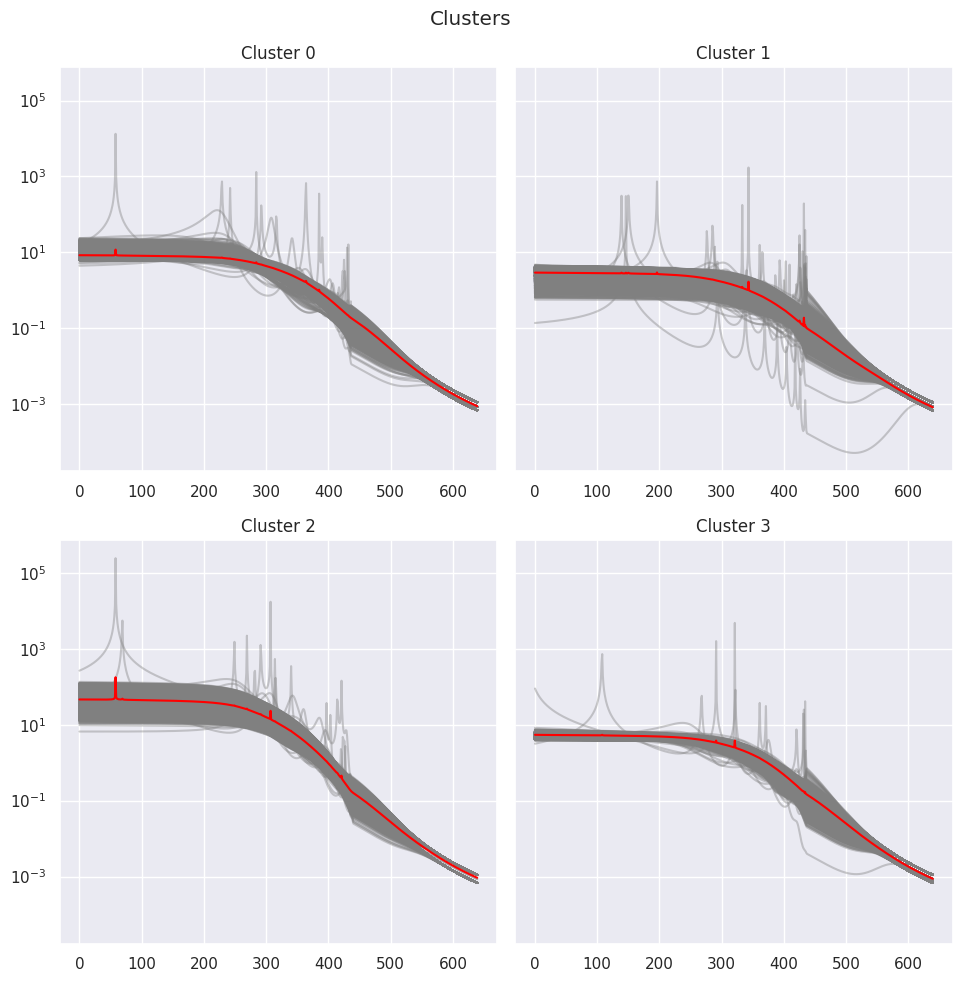

In [7]:
plot_km_results(cluster_count, mag_labels, unscaled_magnetic, scale="log")

### Original data clusters

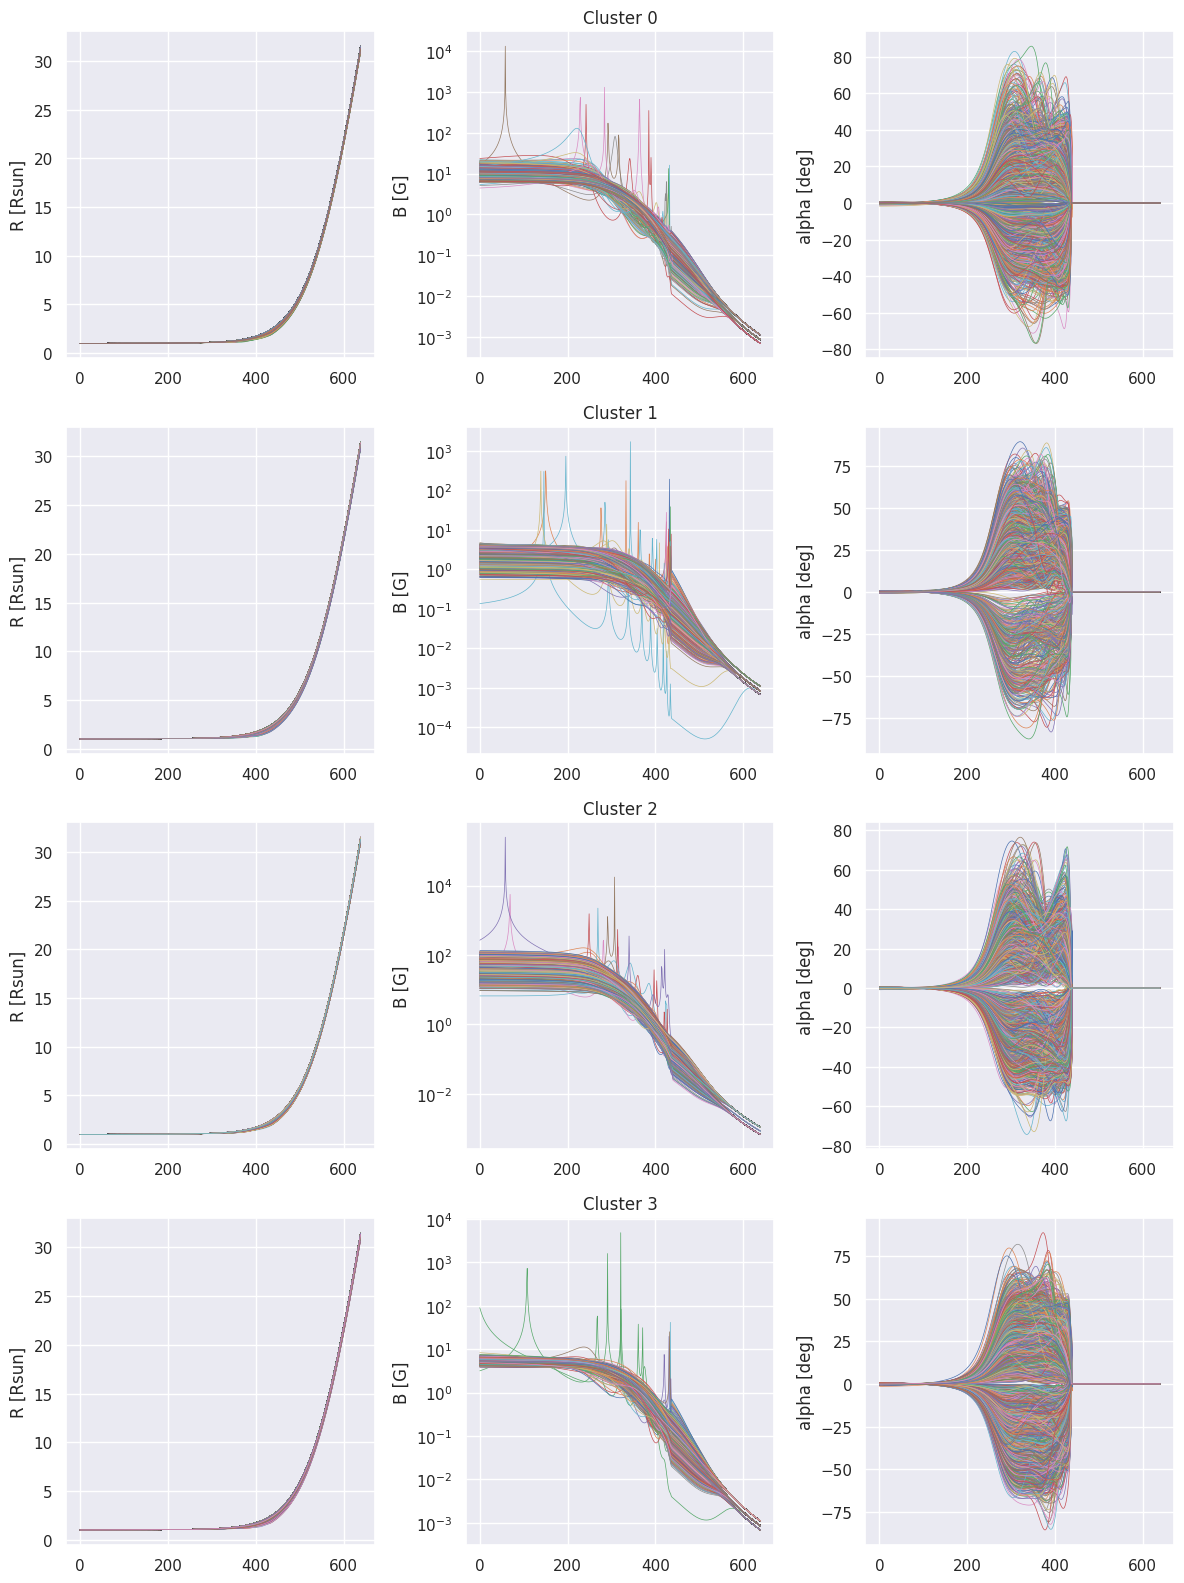

In [8]:
# display unscaled data into clusters
plot_unscaled_clusters(mag_labels, cluster_count, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

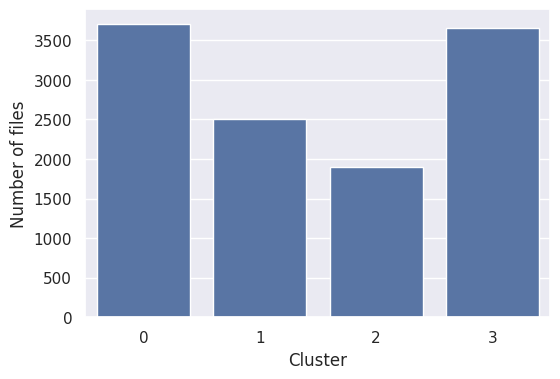

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
bp = sns.countplot(x=mag_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

### Grid Search

In [10]:
# %%capture
# subdir = OUT_DIR / 'mag'
# if not subdir.exists():
#     subdir.mkdir()

# for i in range(2, MAX_CLUSTERS):
#     km = TimeSeriesKMeans(n_clusters=i, metric="euclidean", max_iter=100, random_state=0)
#     mag_labels = km.fit_predict(scaled_magnetic)
#     plot_km_results(i, mag_labels, scaled_magnetic, save_path=subdir / 'kmeans_{}.png'.format(i))
#     plot_unscaled_clusters(mag_labels, i, flows_dict, flow_columns, save_path=subdir / 'kmeans_{}_unscaled.png'.format(i), yscale={'B [G]': 'log'})

# Flux Tube Inclination - alpha [deg]

In [8]:
plt.close("all")

In [9]:
# separate into file series
scaled_alpha = [scaled_flows['alpha [deg]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['alpha [deg]']) // 640)]
scaled_alpha = np.array(scaled_alpha)
scaled_alpha[0][:5]

unscaled_alpha = [unscaled_flows['alpha [deg]'][i*640 : i*640 + 640] for i in range(len(unscaled_flows['alpha [deg]']) // 640)]
unscaled_alpha = np.array(unscaled_alpha)


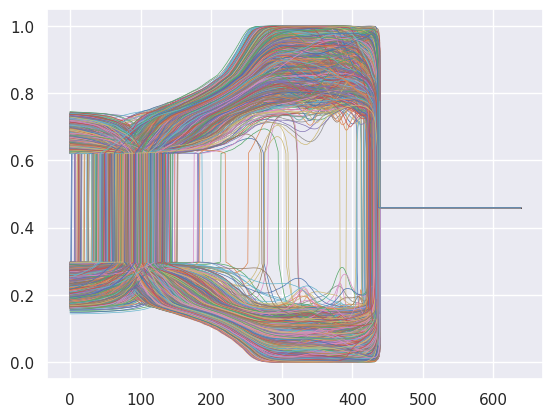

In [10]:
# plot scaled magnetic field
for a_line in scaled_alpha:
    plt.plot(a_line, linewidth=0.5)

# plt.yscale('linear')

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

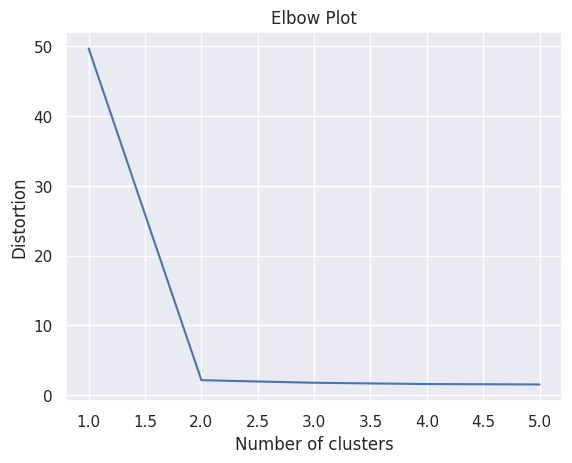

In [13]:
distortions = []
K = range(1,6)
for i in K:
    km = TimeSeriesKMeans(n_clusters=i, metric="euclidean", max_iter=500, random_state=0)
    km.fit(scaled_alpha)
    distortions.append(km.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')

In [11]:
adf = clustering_metrics(TimeSeriesKMeans, scaled_alpha, {"random_state" : 0, "metric" : "euclidean", "max_iter" : 500})
adf

,n_clusters,silhouette,davies_bouldin,calinski_harabasz
0,2,0.865105,0.190166,263222.493764
1,3,0.499297,1.077765,160481.586359
2,4,0.492992,1.089283,120114.358711
3,5,0.463305,1.123013,93537.500173
4,6,0.479649,1.104108,82431.538989
5,7,0.259078,1.311907,82038.400305
6,8,0.256688,1.305718,76633.300966
7,9,0.251723,1.374274,70313.669845


In [14]:
print(adf.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrrr}
\toprule
n_clusters & silhouette & davies_bouldin & calinski_harabasz \\
\midrule
2 & 0.865 & 0.190 & 263222.494 \\
3 & 0.499 & 1.078 & 160481.586 \\
4 & 0.493 & 1.089 & 120114.359 \\
5 & 0.463 & 1.123 & 93537.500 \\
6 & 0.480 & 1.104 & 82431.539 \\
7 & 0.259 & 1.312 & 82038.400 \\
8 & 0.257 & 1.306 & 76633.301 \\
9 & 0.252 & 1.374 & 70313.670 \\
\bottomrule
\end{tabular}



In [15]:
# rule of thumb number of clusters 
cluster_count = 2
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="euclidean", max_iter=500, random_state=0)
alpha_labels = km.fit_predict(scaled_alpha)

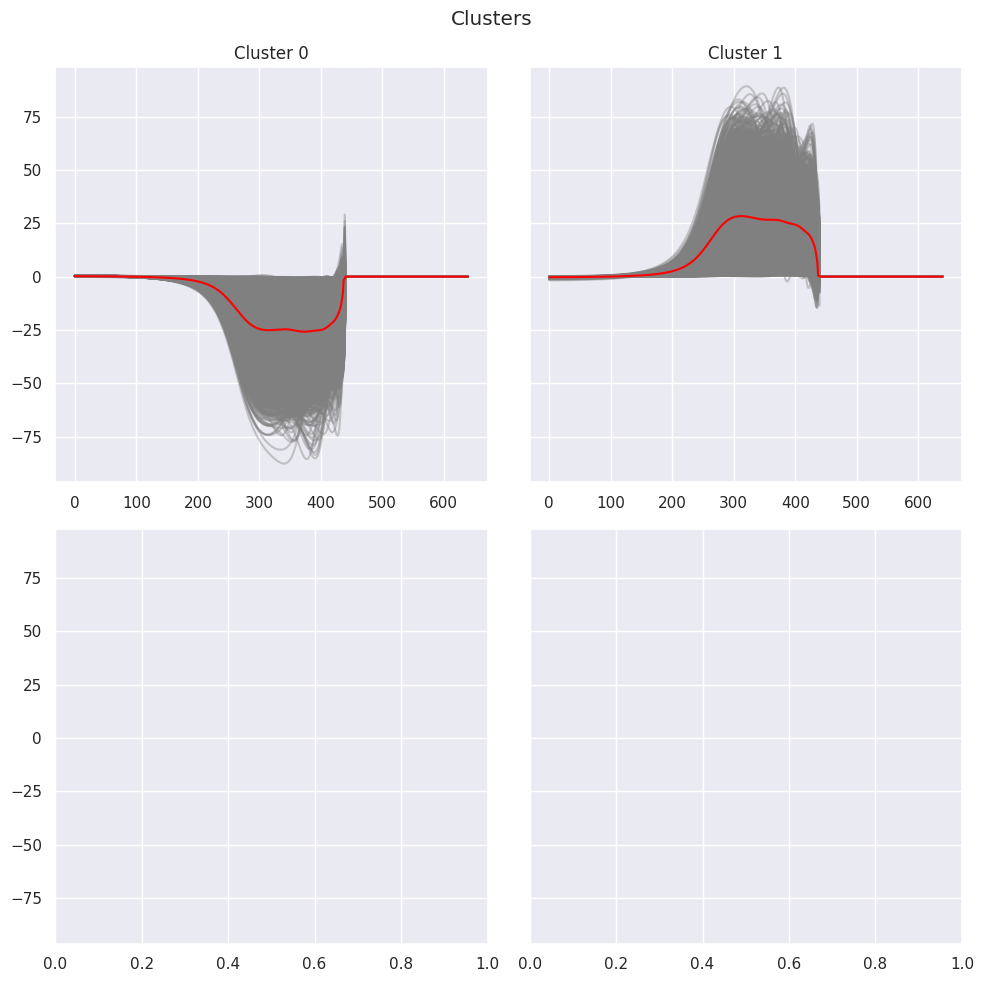

In [16]:
plot_km_results(cluster_count, alpha_labels, unscaled_alpha, scale='linear')

### Original Data Clusters

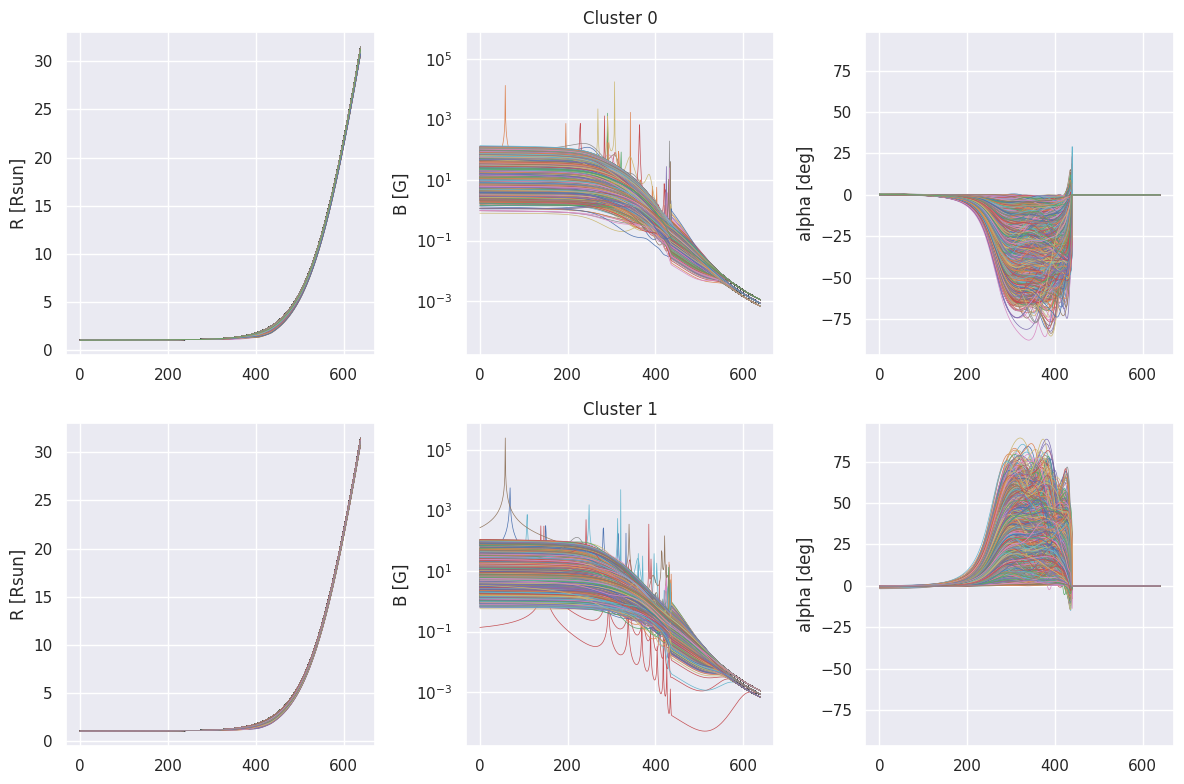

In [17]:
plot_unscaled_clusters(alpha_labels, cluster_count, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

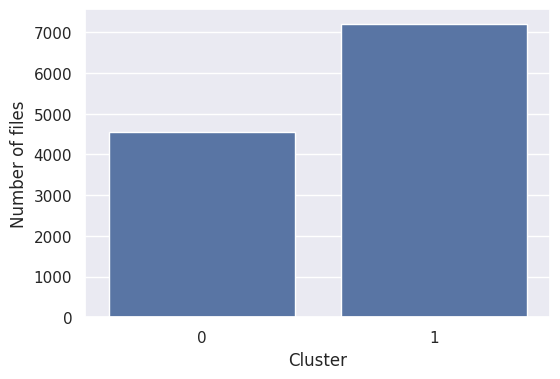

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))
bp = sns.countplot(x=alpha_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

### Grid Search

In [19]:
# %%capture
# subdir = OUT_DIR / 'alpha'
# if not subdir.exists():
#     subdir.mkdir()
    
# for i in range(2, MAX_CLUSTERS):
#     km = TimeSeriesKMeans(n_clusters=i, metric="euclidean", max_iter=100, random_state=0)
#     alpha_labels = km.fit_predict(scaled_alpha)
#     plot_km_results(i, alpha_labels, scaled_alpha, save_path=subdir / 'kmeans_{}.png'.format(i))
#     plot_unscaled_clusters(alpha_labels, i, flows_dict, flow_columns, save_path=subdir / 'kmeans_{}_unscaled.png'.format(i))